In [3]:
using LinearAlgebra
using Statistics
using Plots
using StatsPlots
using BenchmarkTools

In [4]:
# helper methods
function symmetric_matrix(dim::Integer, show_matrix::Bool=false)::Matrix
    A = ones(dim,dim);
    for i = 1:dim
        for j = 1:i
            A[i,j] = rand(1:50);
            A[j,i] = A[i,j];
        end
    end
    if show_matrix
        display(A);
    end
    return A;
end

# we might change it to just rand(dim,dim)
function random_matrix(dim::Integer, show_matrix::Bool=false)::Matrix
    A = ones(dim, dim);
    for i = 1:dim
        for j = 1:dim
            A[i,j] = rand(1:50);
        end
    end
    if show_matrix
        display(A);
    end
    return A
end

function diagonal_matrix(dim::Integer)::Matrix
    Diag = ones(dim,dim)
    return Diagonal(Diag)
end

function eye(dim::Integer)::Matrix
    return Matrix{Float64}(I,n,n);
end


function custom_cond(λₘₐₓ, λₘᵢₙ)
    return sqrt(λₘₐₓ/λₘᵢₙ)
end

function get_diag(A::Matrix)::Array #get diagonal as vector
    dim = size(A,1)
    diag = Array{Float64}(undef, dim)
    for i=1:dim
        diag[i] = A[i,i]
    end
    return diag
end

get_diag (generic function with 1 method)

# Metoda potęgowa

Poniżej przygotowana jest funkcja do metody iteracji prostej (metoda potęgowa), dzięki której można wyznaczyć największą co do modułu wartość własną, czyli promień spektralny macierzy, który opisany jest wzorem:
## $$\rho(A) = |\lambda_{max}| = \lim_{i \to \infty} \frac{||t_{i+1}||_{\infty}}{||t_{i}||_{\infty}}$$

Przy założeniu, że dowolny wektor początkowy t_{0} != 0, do uzyskania promienia spektralnego prowadzą iteracje postaci:
## $$t_{i+1} = At_{i},\ i=0,1,2...$$



In [5]:
function power_eigen(A::Matrix, iterations::Integer)::Array
    n = size(A, 1);
    x = ones(n,1);
    x1 = x;
    
    for i = 1:iterations
        x1 = x;
        x = A * x;
        x = x / norm(x);
    end
    return x' * A * x1 / (x' * x1);
end

function power_eigen_min(A::Matrix, iterations::Integer)::Array
    n = size(A, 1);
    x = ones(n,1);
    x1 = x;
    for i = 1:iterations
        x1 = x;
        x = A \ x;
        x = x / norm(x);
    end

    return x' * A * x1 / (x' * x1);
end

function power_eigen_stop(A::Matrix, max_iterations::Integer=1000, error::Float64=1e-6)::Array
    n = size(A, 1);
    x = ones(n,1);
    x1 = x;
    eig = nothing
    for i = 1:max_iterations
        x1 = x;
        x = A * x;
        x = x / norm(x);
        
        new_eig = x' * A * x1 / (x' * x1)

        if eig != nothing && abs(new_eig[1] - eig) < error
            return new_eig
        end
        eig = new_eig[1]
    end
    return eig;
end

power_eigen_stop (generic function with 3 methods)

In [6]:
A = symmetric_matrix(5);
#A = random_matrix(5);
#A = [22 21 -8 4; 21 49 11 39; -8 11 60 -19; 4 39 -19 135]
λₘₐₓ = power_eigen(A, 20);
λₘᵢₙ = power_eigen_min(A,20);
display(λₘₐₓ);
display(λₘᵢₙ);
e, v = eigen(A);
display(e);

1×1 Array{Float64,2}:
 118.92219280451084

1×1 Array{Float64,2}:
 17.26344669485738

5-element Array{Float64,1}:
 -36.427095947320915
 -29.8341604734738
  17.263444075193895
  56.07561954108951
 118.92219280451093

In [7]:
# benchmark time for above Matrix
@btime  power_eigen(A, 20); # λₘₐₓ
@btime  power_eigen_min(A,20); # λₘᵢₙ

  5.750 μs (47 allocations: 5.72 KiB)
  16.299 μs (87 allocations: 13.84 KiB)


Jak widać z wyniku wykonania powyższego kodu, uzyskaliśmy największą co do modułu wartość własną macierzy. Ta wartość zgadza się z wartością otrzymaną za pomocą metody eigen(A). Za pomocą metody potęgowej można również wyznaczyć najmniejszą co do modułu wartość własną macierzy. Korzysta się z twierdzenia dotyczącego przesunięcia spektrum macierzy:<br />
### "Jeżeli $\lambda$ jest wartością własną macierzy A, to $\lambda + r$ jest wartością własną macierzy $A + \tau I$"
Należy pamiętać, że twierdzenie ma zastosowanie dla macierzy symetrycznych i dodatnio określonych. Po zastosowaniu przesunięcia $B = A - \lambda_{max}I$ można ponownie zastosować metodę iteracji prostej dla macierzy B zbieżną do największej co do modułu wartości własnej $\lambda = \lambda_{min}-\lambda_{max}$. Stąd można wyznaczyć $\lambda_{min}$.

In [8]:
B = A' * A;
λₘₐₓ = power_eigen(B, 50);
n = size(A,1);
B_min = B - λₘₐₓ .* eye(n);
lambda_dash = power_eigen(B_min, 50);
λₘᵢₙ = lambda_dash + λₘₐₓ;

Mając największą i najmniejszą wartość własną macierzy, można wyznaczyć współczynnik uwarunkowania macierzy:
$$cond(A)=\sqrt{\frac{\lambda_{max}(A^TA)}{\lambda_{min}(A^TA)}}$$
We wzorze przyjęto, że macierz A jest symetryczna, co oznacza, że $A=A^T$, ewentualnie można macierz wejściową doprowadzić do postaci symetrycznej stosując wzór $B = A^TA$

In [9]:
value = custom_cond(λₘₐₓ, λₘᵢₙ)
print(value)

cond(A)

[4.702213210929895]

6.888671361665987

# Metoda Jacobiego

In [10]:
function jacobi_eigen(A::Matrix, iterations::Integer)::Matrix
    n = size(A,1);
    for i = 1:iterations
        s,t = maxst(A);
        
        d = √((A[s,s] - A[t,t])^2 + 4 * A[s,t]^2);
        sin2t = 2 * A[s,t] / d;
        cos2t = (A[s,s] - A[t,t]) / d;
        dt = sqrt(2 * (1 + cos2t));
        sint = abs(sin2t) / dt;
        cost = abs((1 + cos2t) / dt);
        cost = sign(A[s,t]) * cost;

        R = diagonal_matrix(n);
        R[s,s] = cost;
        R[t,t] = cost;
        R[s,t] = -sint;
        R[t,s] = sint;
        
        A = R' * A * R; 
        
    end
    return A
end

function jacobi_eigen_stop(A::Matrix, max_iterations::Integer=1000, error::Float64=1e-2)::Matrix
    n = size(A,1);
    eigs = nothing
    for i = 1:max_iterations
        s,t = maxst(A);
        
        d = √((A[s,s] - A[t,t])^2 + 4 * A[s,t]^2);
        sin2t = 2 * A[s,t] / d;
        cos2t = (A[s,s] - A[t,t]) / d;
        dt = sqrt(2 * (1 + cos2t));
        sint = abs(sin2t) / dt;
        cost = abs((1 + cos2t) / dt);
        cost = sign(A[s,t]) * cost;

        R = diagonal_matrix(n);
        R[s,s] = cost;
        R[t,t] = cost;
        R[s,t] = -sint;
        R[t,s] = sint;
        
        A = R' * A * R;
        
        new_eigs = get_diag(A)
        if eigs != nothing && !any(broadcast(abs, new_eigs .- eigs) .> error)
            return A
        end
        eigs = new_eigs
        
    end
    return A
end

function maxst(A::Matrix)::Tuple{Integer,Integer}
    s = 1;
    t = 2;
    n = size(A,1);
    for c = 2:n
        for r = 1:c-1
            if abs(A[r,c]) > abs(A[s,t])
                s = r;
                t = c;
            end
        end
    end
    return s, t
end

maxst (generic function with 1 method)

In [11]:
#F = [12 6 -6 1; 6 16 2 100; -6 2 16 1 ;1 100 1 4];
#F = rand(4,4);
F = symmetric_matrix(5,true)
FJ = jacobi_eigen(F, 15);

n = size(FJ,1);
FJ = Diagonal(FJ)

display(FJ)
e,v = eigen(F);
display(e)


5×5 Array{Float64,2}:
 43.0  42.0  29.0  10.0   5.0
 42.0  20.0  33.0  11.0   9.0
 29.0  33.0   8.0  42.0  32.0
 10.0  11.0  42.0  12.0  14.0
  5.0   9.0  32.0  14.0  40.0

5×5 Diagonal{Float64,Array{Float64,1}}:
 118.541    ⋅        ⋅         ⋅         ⋅ 
    ⋅     45.6645    ⋅         ⋅         ⋅ 
    ⋅       ⋅      11.5304     ⋅         ⋅ 
    ⋅       ⋅        ⋅      -12.2595     ⋅ 
    ⋅       ⋅        ⋅         ⋅      -40.4761

5-element Array{Float64,1}:
 -40.4901038365851
 -12.260519769996158
  11.473465988267272
  45.723619884890645
 118.55353773342293

In [12]:
# benchmark time for above Matrix
@btime jacobi_eigen(F, 15);

  10.699 μs (75 allocations: 18.75 KiB)


# QR algorithm

In [13]:
function QR_eigen(A::Matrix, iterations::Integer)::Matrix
    for k = 1:iterations
        Q, R = mgs(A);
        A = R * Q;
    end
    return A;
end

function QR_eigen_stop(A::Matrix, max_iterations::Integer=1000, error::Float64=1e-2)::Matrix
    eigs = nothing
    for k = 1:max_iterations
        Q, R = mgs(A);
        A = R * Q;
        new_eigs = get_diag(A)
        if eigs != nothing && !any(x -> x > error, broadcast(abs, new_eigs .- eigs)) 
            return A
        end
        eigs = new_eigs
    end
    return A;
end

function mgs(A::Matrix)::Tuple{Matrix, Matrix}
    n = size(A,1);
    R = zeros(n,n);
    Q = zeros(n,n);
    for j = 1:n
        v = A[:,j];
        for i = 1:j-1
            R[i,j] = Q[:,i]' * v;
            v = v - R[i,j] * Q[:,i];
        end
        R[j,j] = norm(v);
        Q[:,j] = v / R[j,j];
    end

    return Q, R;
end

mgs (generic function with 1 method)

In [14]:
A = symmetric_matrix(5);
AQR = QR_eigen(A, 30);
Diag = Diagonal(AQR);
display(Diag);

e, v = eigen(A);
display(e)

5×5 Diagonal{Float64,Array{Float64,1}}:
 98.6413    ⋅        ⋅         ⋅     ⋅ 
   ⋅      54.3267    ⋅         ⋅     ⋅ 
   ⋅        ⋅      26.4149     ⋅     ⋅ 
   ⋅        ⋅        ⋅      -14.36   ⋅ 
   ⋅        ⋅        ⋅         ⋅    9.977

5-element Array{Float64,1}:
 -14.359983340213546
   9.977003492352194
  26.41493468366793
  54.326742911945466
  98.64130225224771

In [15]:
@btime QR_eigen(A, 30);

  82.201 μs (1590 allocations: 212.81 KiB)


# Badania

Poniższe wykresy prezentują zbieżność tylko dla największych wartości własnych, ponieważ metoda potęgowa wyznacza tylko pojedynczą wartość.

In [16]:
function plot_eigenvalues(PlotA::Matrix, min_iterations::Integer, max_iterations::Integer, show_all_in_one::Bool=false, err::Bool=false)
    if max_iterations < min_iterations
        return
    end

    x = min_iterations:max_iterations;
    results_power = zeros(0);
    results_jacobi = zeros(0);
    results_qr = zeros(0);
    if !err
        results_eig = zeros(0);
    end
    e, v = eigen(PlotA);
    eigen_lambda = maximum(abs, e);
    
    for i = min_iterations:max_iterations
        #power method
        val = power_eigen(PlotA,i);
        if err
            val = abs(eigen_lambda - val[1]);
        end
        append!(results_power, val);
    
        # jacobi algorithm
        PlotAJ = jacobi_eigen(PlotA, i);
        PlotAJ = Diagonal(PlotAJ);
        val = maximum(abs, PlotAJ);
        if err
            val = abs(eigen_lambda - val[1]);
        end
        append!(results_jacobi, val);
    
        # QR algorithm
        PlotAQR = QR_eigen(PlotA, i);
        PlotAQR = Diagonal(PlotAQR);
        val = maximum(abs, PlotAQR);
        if err
            val = abs(eigen_lambda - val[1]);
        end
        append!(results_qr, val);
        
        # julia eigen()
        if !err
            append!(results_eig, eigen_lambda)
        end
    end
    
    if err
        results = hcat(results_power, results_jacobi, results_qr);
        plot_all = plot(x, results, title= "Lambda max error", label=["power" "jacobi" "QR"], xlabel="iteracje", ylabel="błąd lambda");
        results = results_power;
        plot_power = plot(x, results, title= "Lambda max error", label="power", xlabel="iteracje", ylabel="błąd lambda");
        results = results_jacobi;
        plot_jacobi = plot(x, results, title= "Lambda max error", label="jacobi", xlabel="iteracje", ylabel="błąd lambda");
        results = results_qr;
        plot_qr = plot(x, results, title= "Lambda max error", label="QR", xlabel="iteracje", ylabel="błąd lambda");
    else
        results = hcat(results_eig, results_power, results_jacobi, results_qr);
        plot_all = plot(x, results, title= "Lambda max", label=["eigen" "power" "jacobi" "QR"], xlabel="iteracje", ylabel="wartosc lambda", ylim=(eigen_lambda*0.25, eigen_lambda*1.2));
        results = hcat(results_eig, results_power);
        plot_power = plot(x, results, title= "Lambda max", label=["eigen" "power"], xlabel="iteracje", ylabel="wartosc lambda");
        results = hcat(results_eig, results_jacobi);
        plot_jacobi = plot(x, results, title= "Lambda max", label=["eigen" "jacobi"], xlabel="iteracje", ylabel="wartosc lambda");
        results = hcat(results_eig, results_qr);
        plot_qr = plot(x, results, title= "Lambda max", label=["eigen" "QR"], xlabel="iteracje", ylabel="wartosc lambda");
    end
    if !show_all_in_one
        #show plots separate 
        display(plot_all);
        display(plot_power);
        display(plot_jacobi);
        display(plot_qr);
    else
        # all plots together
        all_plots = plot(plot_all, plot_power, plot_jacobi, plot_qr, size = (800,800), layout = grid(4, 1, heights=[0.25 , 0.25, 0.25, 0.25]));
        display(all_plots);
    end
end


plot_eigenvalues (generic function with 3 methods)

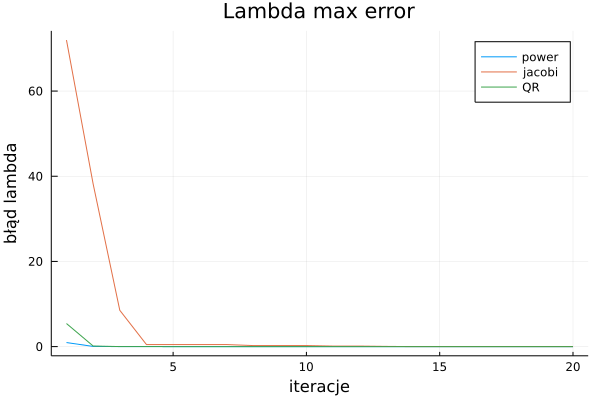

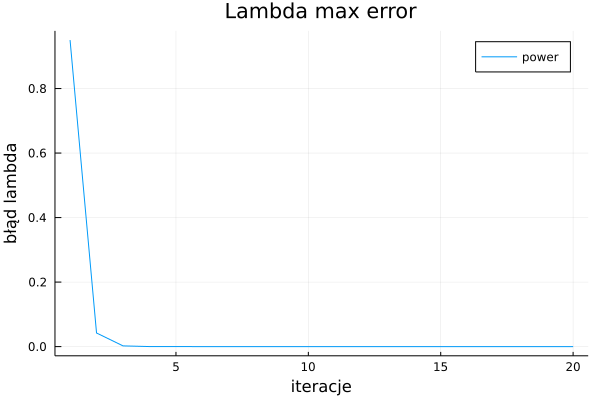

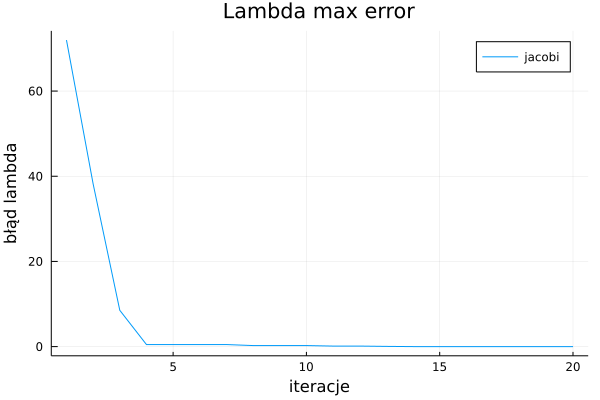

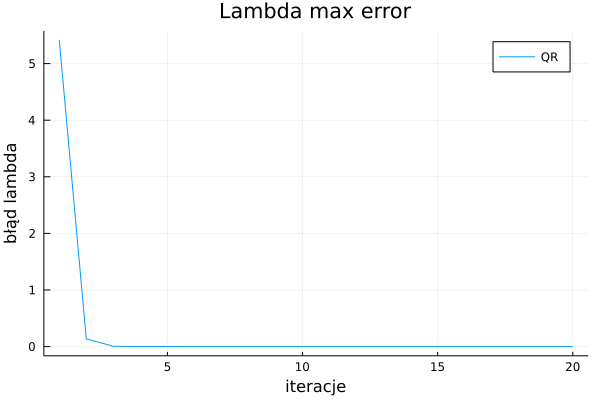

In [17]:
A = symmetric_matrix(5);
plot_eigenvalues(A, 1, 20, false, true);

## Przypadki testowe

metoda potęgowa - macierze o elementach i wartościach własnych rzeczywistych<br />
metoda Jacobiego - macierze symetryczne (w tym hermitowskie)<br />
algorytm QR - macierze niesymetryczne

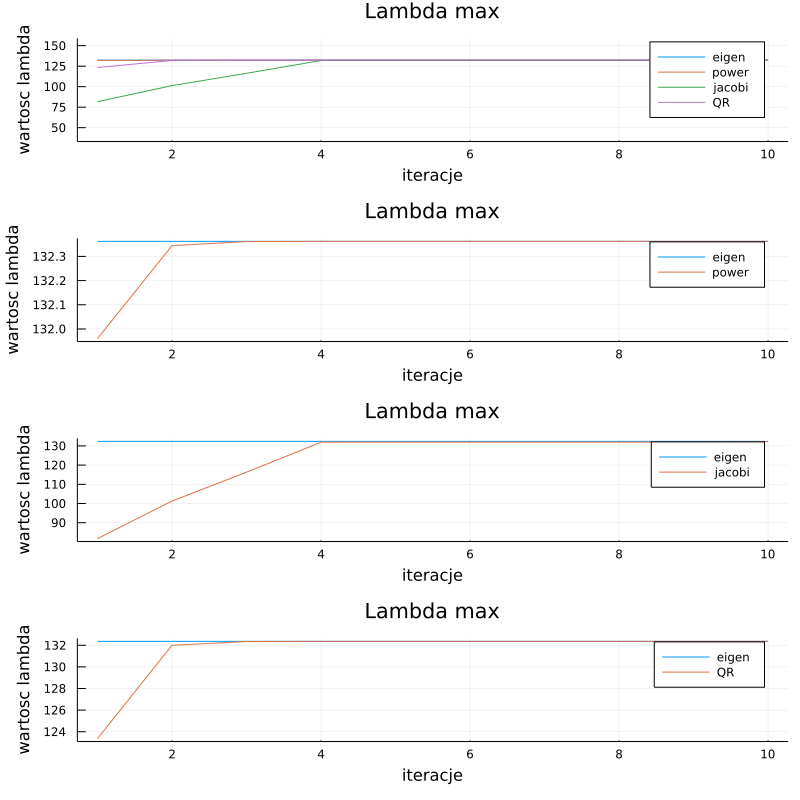

  0.425688 seconds (510.26 k allocations: 25.294 MiB, 2.74% gc time)


In [18]:
Test1 = symmetric_matrix(5)
@time plot_eigenvalues(Test1, 1, 10, true)

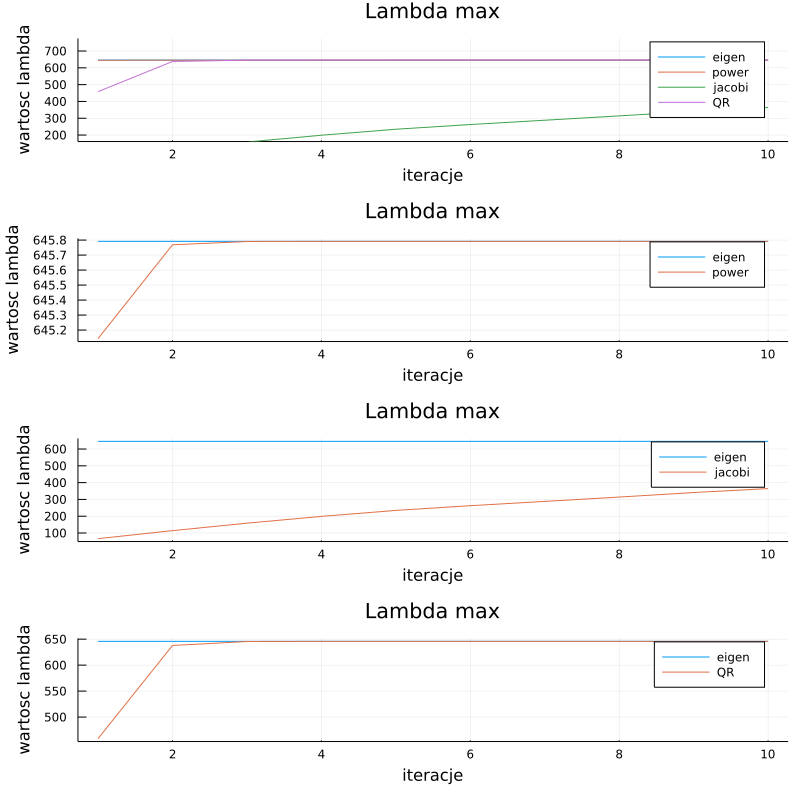

  0.077874 seconds (184.70 k allocations: 25.859 MiB)


In [19]:
Test2 = symmetric_matrix(25)
@time plot_eigenvalues(Test2, 1, 10, true)

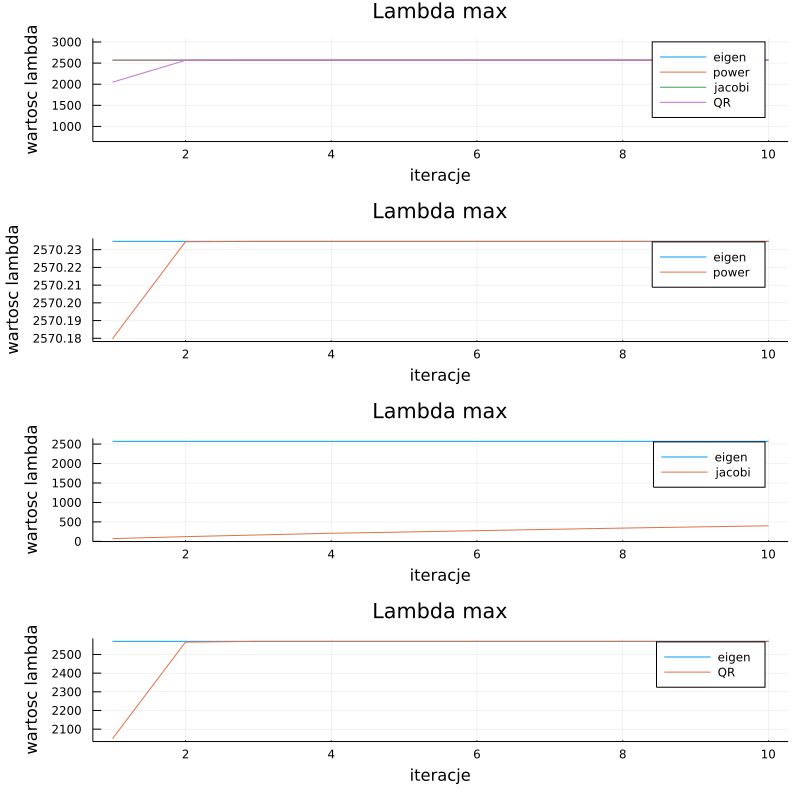

  0.753264 seconds (1.22 M allocations: 974.772 MiB, 20.42% gc time)


In [20]:
Test3 = symmetric_matrix(100)
@time plot_eigenvalues(Test3, 1, 10, true)

Benchmarki dla wszystkich metod przy 3 rozmiarach macierzy:

In [21]:
A = symmetric_matrix(10)
print("Power: ")
@btime power_eigen_stop(A)
print("QR: ")
@btime QR_eigen_stop(A)
print("Jacobi: ")
@btime jacobi_eigen_stop(A);

Power:   7.450 μs (49 allocations: 5.78 KiB)
QR:   1.662 ms (31104 allocations: 5.06 MiB)
Jacobi:   83.500 μs (655 allocations: 256.41 KiB)


In [22]:
A = symmetric_matrix(25)
print("Power: ")
@btime power_eigen_stop(A)
print("QR: ")
@btime QR_eigen_stop(A)
print("Jacobi: ")
@btime jacobi_eigen_stop(A);

Power:   12.099 μs (49 allocations: 8.16 KiB)
QR:   77.141 ms (774950 allocations: 221.49 MiB)
Jacobi:   2.252 ms (3592 allocations: 6.88 MiB)


In [23]:
A = symmetric_matrix(100)
print("Power: ")
@btime power_eigen_stop(A)
print("QR: ")
@btime QR_eigen_stop(A)
print("Jacobi: ")
@btime jacobi_eigen_stop(A);

Power:   75.699 μs (41 allocations: 16.34 KiB)
QR:   5.174 s (20008998 allocations: 16.92 GiB)
Jacobi:   245.352 ms (14995 allocations: 309.05 MiB)


In [24]:
A = symmetric_matrix(100)
@benchmark QR_eigen_stop(A)

BenchmarkTools.Trial: 
  memory estimate:  16.92 GiB
  allocs estimate:  20008998
  --------------
  minimum time:     5.268 s (16.72% GC)
  median time:      5.268 s (16.72% GC)
  mean time:        5.268 s (16.72% GC)
  maximum time:     5.268 s (16.72% GC)
  --------------
  samples:          1
  evals/sample:     1

In [48]:
# plot time benchmarks
#plot for [x1, x2, x3...] iterations
# plot_mean_time(A, [5, 10]);
function plot_mean_time(A::Matrix, iterations::Array, sample::Integer=2000)

    n = size(iterations,1);
    results = zeros(1);
    nam = [];

    for i = 1:n
        power = @benchmark  power_eigen(A, $iterations[$i]) samples = sample;
        power = mean(power.times)/1000;
        jacobi = @benchmark jacobi_eigen(A, $iterations[$i]) samples = sample;
        jacobi = mean(jacobi.times)/1000;
        qr = @benchmark QR_eigen(A, $iterations[$i]) samples = sample;
        qr = mean(qr.times)/1000;
        results = hcat(results, power, jacobi, qr);
        push!(nam, iterations[i]);
        push!(nam, iterations[i]);
        push!(nam, iterations[i]);
    end
    results = results[2:end];
    ctg = repeat(["Power", "Jacobi", "QR"], outer = n)
    
    plot_time = groupedbar(nam, results, group = ctg, xlabel = "Liczba iteracji", ylabel = "Średni czas [µs]",
        title = "Czas wykonania metod dla okreśłonej liczby iteracji", bar_width = 0.67,
        lw = 0, framestyle = :box)
    display(plot_time);
    
end

# plot to reach stop condition
function plot_mean_time(A::Matrix, sample::Integer=5000)
    power = @benchmark  power_eigen_stop(A) samples = sample;
    power = mean(power.times)/1000;
    jacobi = @benchmark jacobi_eigen_stop(A) samples = sample;
    jacobi = mean(jacobi.times)/1000;
    qr = @benchmark QR_eigen_stop(A) samples = sample;
    qr = mean(qr.times)/1000;

    results = [power, jacobi, qr];
    nam = repeat(["time"], inner=3);
    ctg = repeat(["Power", "Jacobi", "QR"], outer = 1)

    display(results);

    plot_time = groupedbar(nam, results, group = ctg, ylabel = "Średni czas [µs]",
        title = "Czas wykonania metod do warunku stopu", bar_width = 0.67,
        lw = 0, framestyle = :box);
    display(plot_time);
end

plot_mean_time (generic function with 4 methods)

3-element Array{Float64,1}:
 11.335299600000003
 25.920163799999997
 88.9229974

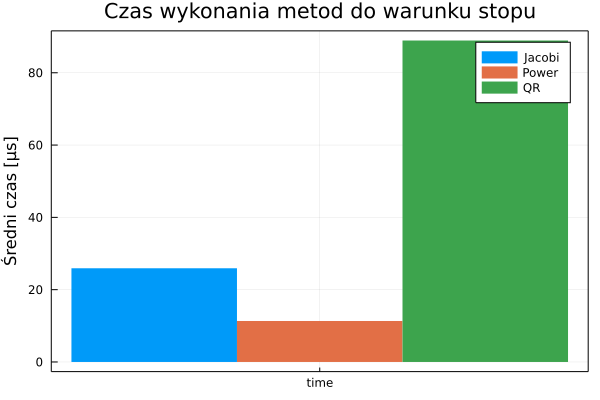

In [49]:
A = symmetric_matrix(5);
plot_mean_time(A);